In [1]:
import keras
import os
from keras.models import Sequential, Model, Input
from keras import regularizers
from keras.callbacks import History
from keras.utils import np_utils
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras.engine import training
from keras.layers import Conv2D, Convolution2D, MaxPooling2D, GlobalAveragePooling2D, Flatten, Dropout, Activation, Average, Dense, Dropout
from keras.losses import categorical_crossentropy
from keras.optimizers import Adam
from keras.utils import to_categorical
from keras.utils import plot_model
from keras.preprocessing.image import load_img, img_to_array
from keras.applications import VGG16
from keras.applications.inception_v3 import InceptionV3
from keras.applications import imagenet_utils
from typing import Tuple, List
import glob
import pandas as pd
import numpy as np
from skimage import feature
import matplotlib.pyplot as plt
# start tensorflow interactiveSession
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
from PIL import Image
from keras import applications
np.random.seed(10)
# Importing sklearn libraries
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score,precision_score, recall_score, confusion_matrix
from sklearn.metrics import f1_score, roc_auc_score, roc_curve
from sklearn import manifold
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import seaborn as sns
import itertools
import gc
import pickle

In [2]:
train_dir = "0318_png\Train"
val_dir = "0318_png\Test"
train = []
train_y = []
val = []
val_y = []
label_train = -1
label_test = -1
for i in sorted(os.listdir(train_dir)):
  label_train+=1
  for img in sorted(os.listdir(train_dir+'/'+i)):
    train.append(os.path.join(train_dir,i,img))
    train_y.append(label_train)
for i in sorted(os.listdir(val_dir)):
  label_test+=1
  for img in sorted(os.listdir(val_dir+'/'+i)):
    val.append(os.path.join(val_dir,i,img))
    val_y.append(label_test)
num_classes = len(os.listdir(train_dir))
y_train = np_utils.to_categorical(train_y, num_classes)
y_val = np_utils.to_categorical(val_y, num_classes)

In [3]:
model_vgg16 = VGG16(weights="imagenet", include_top=False)
model_V3 = InceptionV3(weights="imagenet", include_top=False)

model_cnn = Sequential()
model_cnn.add(Conv2D(32, (3, 3), activation='relu',input_shape = (224,224,3)))
model_cnn.add(MaxPooling2D(pool_size=(2, 2)))

model_cnn.add(Conv2D(64, (3, 3), activation='relu'))
model_cnn.add(MaxPooling2D(pool_size=(2, 2)))

model_cnn.add(Conv2D(64, (3, 3), activation='relu'))
model_cnn.add(MaxPooling2D(pool_size=(2, 2)))

model_cnn.add(Conv2D(128, (3, 3), activation='relu'))
model_cnn.add(MaxPooling2D(pool_size=(2, 2)))

model_cnn.add(GlobalAveragePooling2D())
model_cnn.add(Dense(64, activation='relu'))
model_cnn.add(Dense(num_classes, activation='softmax'))

In [4]:
def create_train(dataset, pre_model):
    x_scratch = []
    # loop over the images
    for imagePath in dataset:
        image = load_img(imagePath, target_size=(224, 224),color_mode="rgb")
        image = img_to_array(image)
        image = np.expand_dims(image, axis=0)
        image = imagenet_utils.preprocess_input(image)
        x_scratch.append(image)       
    x = np.vstack(x_scratch)
    return x
train_x = create_train(train, model_cnn)
val_x = create_train(val, model_cnn)
weights = {}
k_weights = 0
for i in sorted(os.listdir(train_dir)):
    count = len(os.listdir(os.path.join(train_dir,i)))
    weight = train_x.shape[0]/(num_classes*count)
    weights[k_weights] = weight
    k_weights = k_weights+1

In [5]:
# Creating a checkpointer 
checkpointer = ModelCheckpoint(filepath='cnn_model.best.hdf5', 
                               verbose=1,save_best_only=True)
model_cnn.compile(loss='categorical_crossentropy', optimizer='adam',
              metrics=['accuracy'])

#Fitting the model on the train data and labels.
history = model_cnn.fit(train_x, y_train, 
          batch_size=32, epochs=32, class_weight=weights,
          verbose=1, callbacks=[checkpointer], 
          validation_data=(val_x, y_val), shuffle=True)

Epoch 1/32
77/77 [==============================] - 8s 61ms/step - loss: 7.7687 - accuracy: 0.0646 - val_loss: 2.7543 - val_accuracy: 0.2681

Epoch 00001: val_loss improved from inf to 2.75428, saving model to cnn_model.best.hdf5
Epoch 2/32
77/77 [==============================] - 4s 50ms/step - loss: 2.7981 - accuracy: 0.2607 - val_loss: 2.1982 - val_accuracy: 0.3240

Epoch 00002: val_loss improved from 2.75428 to 2.19818, saving model to cnn_model.best.hdf5
Epoch 3/32
77/77 [==============================] - 4s 57ms/step - loss: 2.3058 - accuracy: 0.3435 - val_loss: 1.7442 - val_accuracy: 0.4569

Epoch 00003: val_loss improved from 2.19818 to 1.74417, saving model to cnn_model.best.hdf5
Epoch 4/32
77/77 [==============================] - 4s 50ms/step - loss: 1.9753 - accuracy: 0.4281 - val_loss: 1.3818 - val_accuracy: 0.6270

Epoch 00004: val_loss improved from 1.74417 to 1.38182, saving model to cnn_model.best.hdf5
Epoch 5/32
77/77 [==============================] - 4s 49ms/step - l

In [22]:
from keras.models import load_model
model_cnn1 = Sequential()
for layer in model_cnn.layers[:-3]: # go through until last layer
    model_cnn1.add(layer)

In [7]:
class LocalBinaryPatterns:
    def __init__(self, numPoints, radius):
        # store the number of points and radius
        self.numPoints = numPoints
        self.radius = radius

    def describe(self, image, eps=1e-7):
        # compute the Local Binary Pattern representation
        # of the image, and then use the LBP representation
        # to build the histogram of patterns
        lbp = feature.local_binary_pattern(image, self.numPoints,
            self.radius, method="uniform")
        (hist, _) = np.histogram(lbp.ravel(),
            bins=np.arange(0, self.numPoints + 3),
            range=(0, self.numPoints + 2))

        # normalize the histogram
        hist = hist.astype("float")
        hist /= (hist.sum() + eps)

        # return the histogram of Local Binary Patterns
        return hist
def create_vgg_features(dataset, pre_model):
    
    x_scratch = []
    from keras.applications.vgg16 import preprocess_input
    for imagePath in dataset:
        image = load_img(imagePath, target_size=(224, 224),color_mode="rgb")
        image = img_to_array(image)
        image = np.expand_dims(image, axis=0)
        image = preprocess_input(image)
        x_scratch.append(image)        
    x = np.vstack(x_scratch)
    features = pre_model.predict(x, batch_size=32)
    features_flatten = features.reshape((features.shape[0], 7 * 7 * 512))
    del x, features
    gc.collect()
    return features_flatten
def create_v3_features(dataset, pre_model):
    
    x_scratch = []
    from keras.applications.inception_v3 import preprocess_input
    for imagePath in dataset:
        image = load_img(imagePath, target_size=(224, 224),color_mode="rgb")
        image = img_to_array(image)
        image = np.expand_dims(image, axis=0)
        image = preprocess_input(image)
        x_scratch.append(image)      
    x = np.vstack(x_scratch)
    features = pre_model.predict(x, batch_size=32)
    features_flatten = features.reshape((features.shape[0], 5 * 5 * 2048))
    del x, features
    gc.collect()
    return features_flatten
def create_cnn_feature(dataset, pre_model):
    
    x_scratch = []
    for imagePath in dataset:
        image = load_img(imagePath, target_size=(224, 224),color_mode="rgb")
        image = img_to_array(image)
        image = np.expand_dims(image, axis=0)
        image = imagenet_utils.preprocess_input(image)
        x_scratch.append(image)        
    x = np.vstack(x_scratch)
    features = pre_model.predict(x, batch_size=32)
    features_flatten = features.reshape((features.shape[0], 12 * 12 * 128))
    del x, features
    gc.collect()
    return features_flatten
def create_lbp_features(dataset):
    
    x_scratch = []
    # loop over the images
    for imagePath in dataset:
        image = load_img(imagePath,color_mode="grayscale")
        desc = LocalBinaryPatterns(24, 8)
        #desc = LocalBinaryPatterns(16, 2)
        hist = desc.describe(image)
        x_scratch.append(hist)        
    x = np.vstack(x_scratch)
    return x

In [8]:
vgg_train_features_flatten = create_vgg_features(train, model_vgg16)
vgg_val_features_flatten = create_vgg_features(val, model_vgg16)
v3_train_features_flatten = create_v3_features(train, model_V3)
v3_val_features_flatten = create_v3_features(val, model_V3)
cnn_features_flatten = create_cnn_feature(train, model_cnn1)
cnn_val_features_flatten = create_cnn_feature(val, model_cnn1)
train_lbp_features_flatten = create_lbp_features(train)
val__lbp_features_flatten = create_lbp_features(val)
x = np.append(vgg_train_features_flatten,v3_train_features_flatten,axis=1)
x = np.append(x,cnn_features_flatten,axis=1)
x = np.append(x,train_lbp_features_flatten,axis=1)
y = np.append(vgg_val_features_flatten,v3_val_features_flatten,axis=1)
y = np.append(y,cnn_val_features_flatten,axis=1)
y = np.append(y,val__lbp_features_flatten,axis=1)

In [9]:
scaler = StandardScaler()

# Fit on training set only.
scaler.fit(x)

# Apply transform to both the training set and the test set.
x = scaler.transform(x)
y = scaler.transform(y)

pca = PCA(.95)

pca.fit(x)
x = pca.transform(x)
y = pca.transform(y)
logisticRegr = LogisticRegression(solver = 'lbfgs',class_weight= weights)
logisticRegr.fit(x, train_y)
score = logisticRegr.score(y, val_y)
print(score)
pickle.dump(pca, open("pca_mode.pkl","wb"))
pickle.dump(logisticRegr, open('logistic_model.sav', 'wb'))

C:\Users\aragorn\anaconda3\envs\python37\lib\site-packages\sklearn\linear_model\_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


0.9883449883449883


In [10]:
def generate_model_report(y_actual, y_predicted):
    print("Accuracy = " , accuracy_score(y_actual, y_predicted))
    print("Precision = " ,precision_score(y_actual, y_predicted,average='weighted'))
    print("Recall = " ,recall_score(y_actual, y_predicted,average='weighted'))
    print("F1 Score = " ,f1_score(y_actual, y_predicted,average='weighted'))
    pass

def generate_auc_roc_curve(clf, X_test):
    y_pred_proba = clf.predict_proba(X_test)[:, 1]
    fpr, tpr, thresholds = roc_curve(val_y,  y_pred_proba, pos_label=i)
    auc = roc_auc_score(val_y, y_pred_proba)
    plt.plot(fpr,tpr,label="AUC ROC Curve with Area Under the curve ="+str(auc))
    plt.legend(loc=4)
    plt.show()
    pass

In [11]:
generate_model_report(val_y, logisticRegr.predict(y))

Accuracy =  0.9883449883449883
Precision =  0.9894045348590804
Recall =  0.9883449883449883
F1 Score =  0.988471090874937


confusion matrix

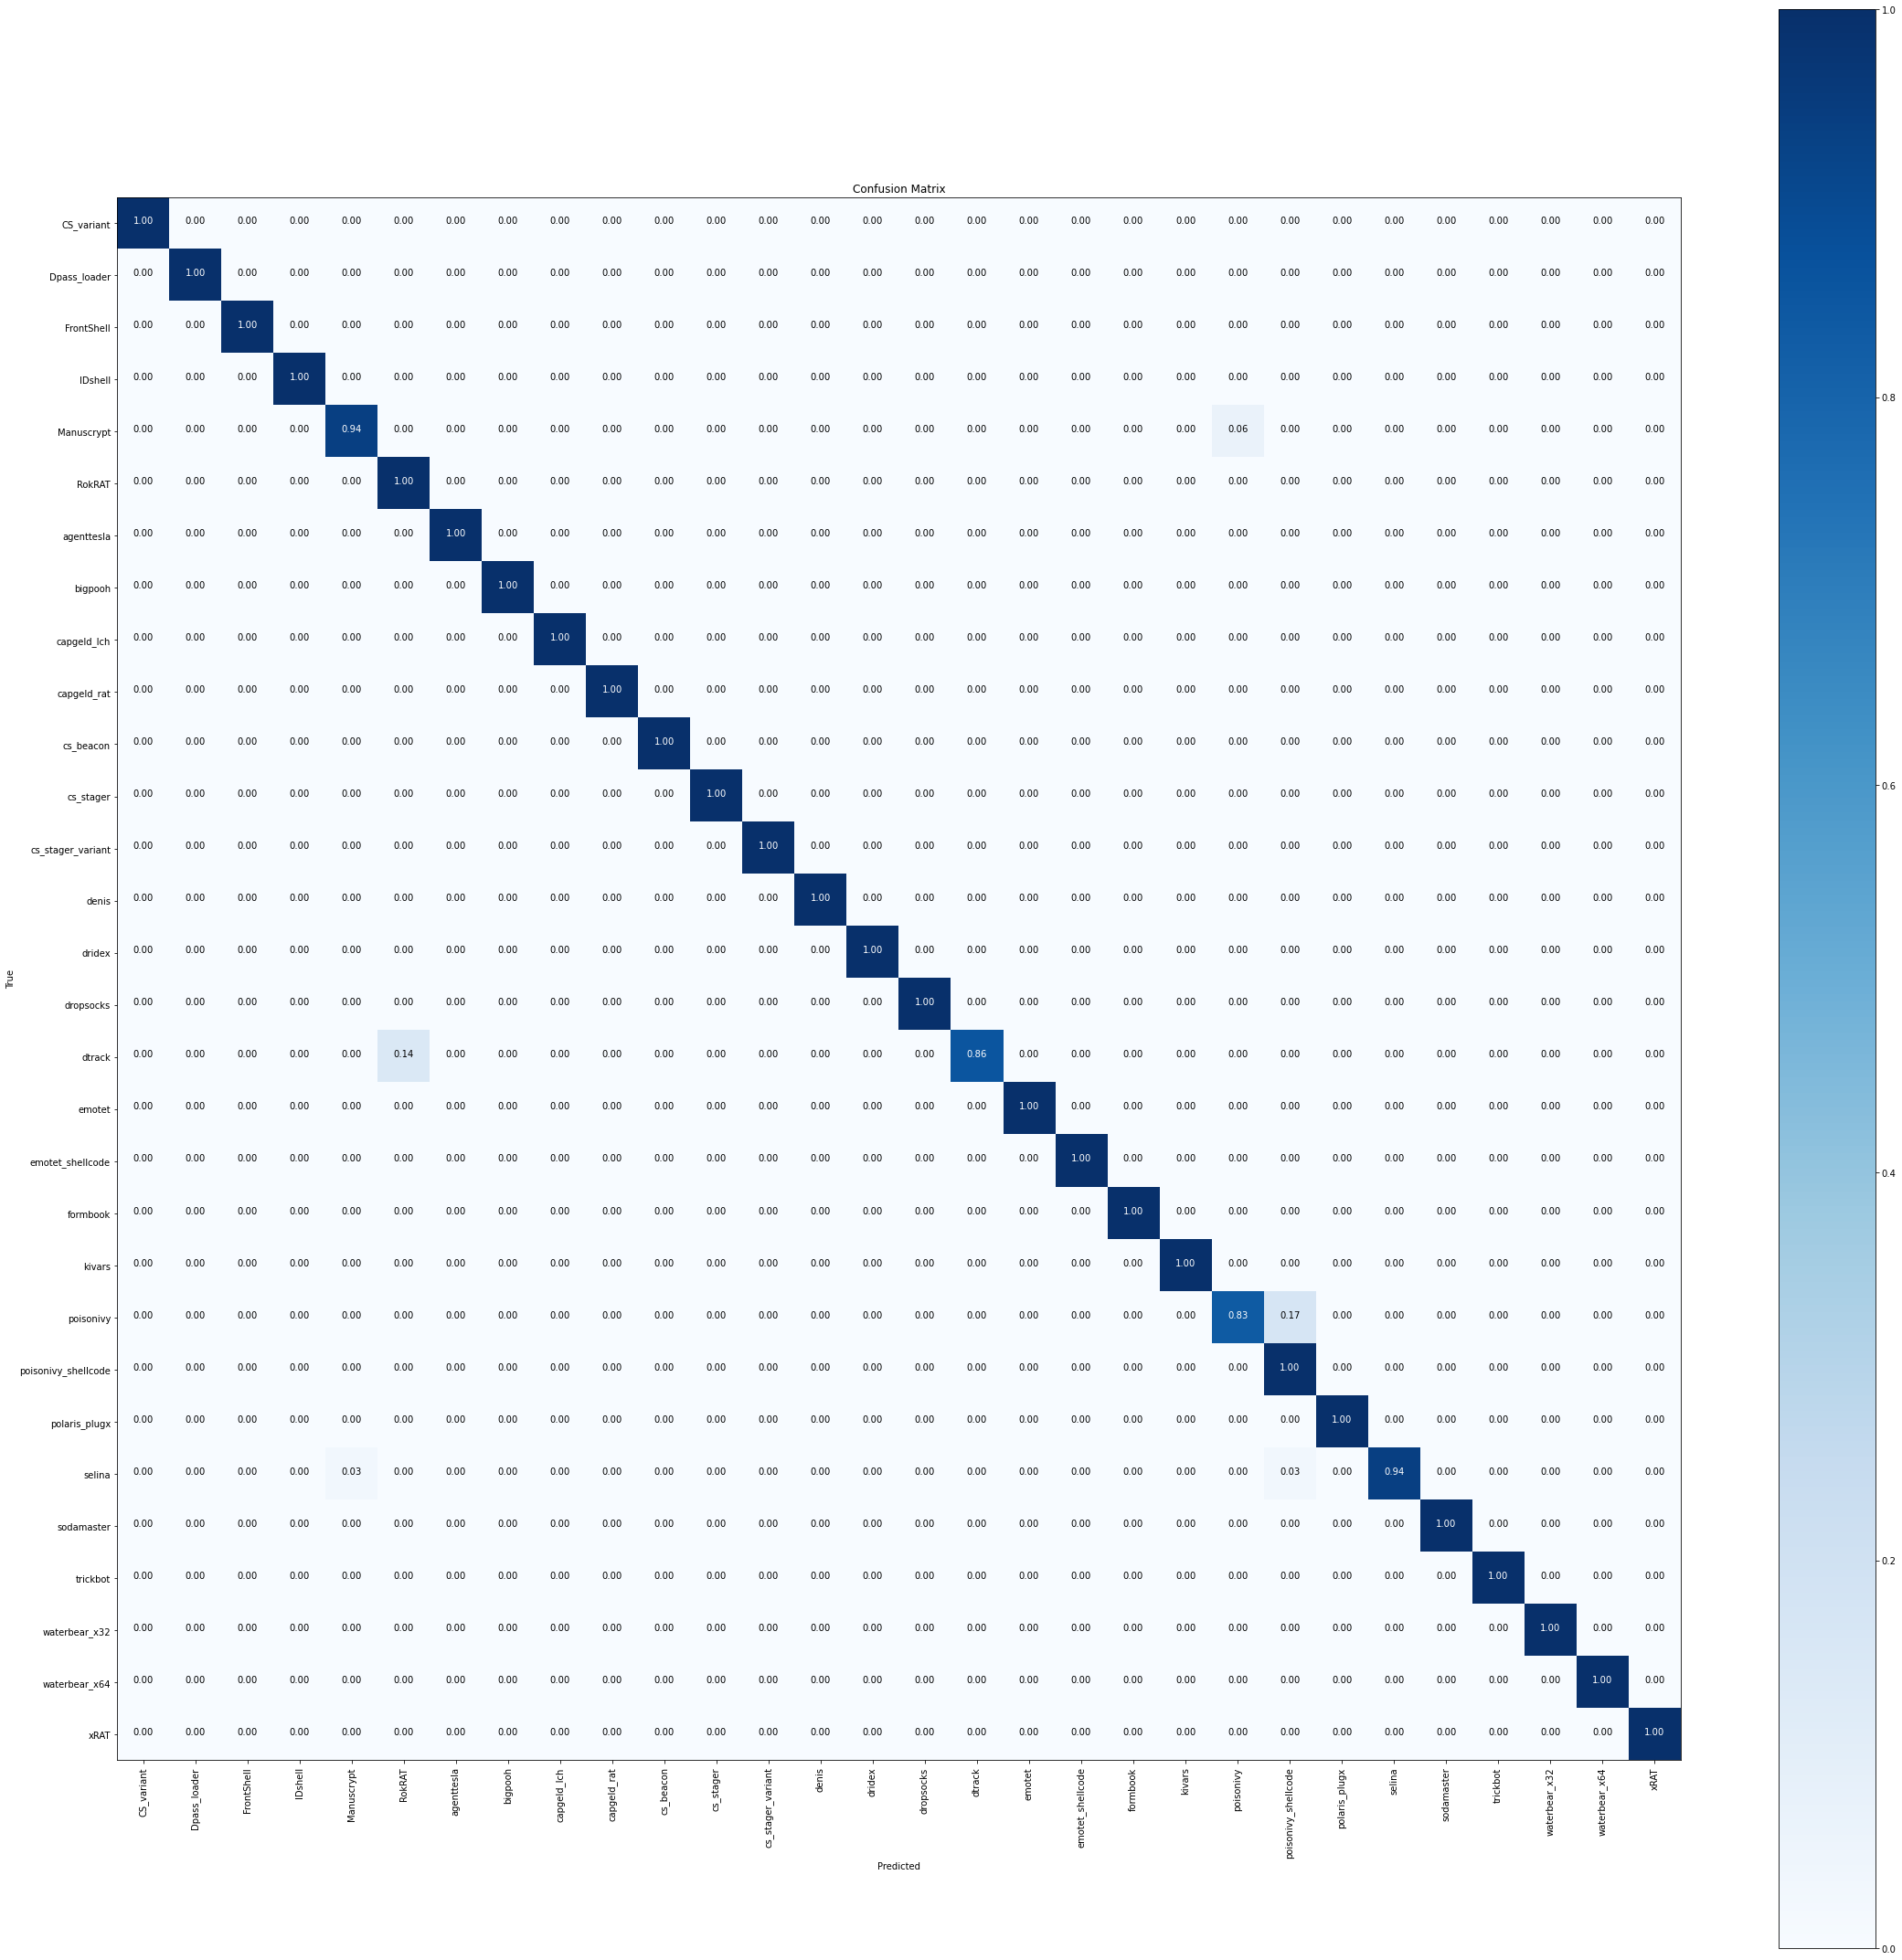

In [12]:
dict = {}
k = 0
for i in sorted(os.listdir(val_dir)):
    dict[k] = i
    k = k+1
cls_pred = logisticRegr.predict(y)
cls_pred = np.expand_dims(cls_pred, axis=1) # make same shape as y_test
cm = confusion_matrix(y_true=val_y,y_pred=cls_pred)
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
f = plt.figure(figsize=(30,30))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.tight_layout()
plt.title("Confusion Matrix")
tick_marks = np.arange(num_classes)
plt.colorbar()
fmt = '.2f' 
thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], fmt),
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

plt.xticks(tick_marks, dict.values(),rotation=90)
plt.yticks(tick_marks, dict.values())
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

TSNE

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 429 samples in 0.001s...
[t-SNE] Computed neighbors for 429 samples in 0.012s...
[t-SNE] Computed conditional probabilities for sample 429 / 429
[t-SNE] Mean sigma: 58.920180
[t-SNE] KL divergence after 250 iterations with early exaggeration: 70.324883
[t-SNE] KL divergence after 1000 iterations: 0.501843


(<Figure size 1080x1080 with 1 Axes>,
 <AxesSubplot:>,
 [Text(-9.632705, 9.466232, 'CS_variant'),
  Text(-12.656974, -15.919858, 'Dpass_loader'),
  Text(-2.8758051, -5.4384594, 'FrontShell'),
  Text(-17.350765, 1.5072752, 'IDshell'),
  Text(-2.695609, 1.6374046, 'Manuscrypt'),
  Text(-2.6004212, 2.7460754, 'RokRAT'),
  Text(-36.805153, 4.6168027, 'agenttesla'),
  Text(6.02068, -4.6458473, 'bigpooh'),
  Text(-13.778456, -7.487447, 'capgeld_lch'),
  Text(-4.601313, -9.271226, 'capgeld_rat'),
  Text(-3.7895975, 10.412565, 'cs_beacon'),
  Text(13.917369, -21.694643, 'cs_stager'),
  Text(-7.429618, 6.829569, 'cs_stager_variant'),
  Text(10.700186, 7.2988753, 'denis'),
  Text(38.110817, 21.556631, 'dridex'),
  Text(2.2611046, 14.550631, 'dropsocks'),
  Text(4.481176, 2.8562353, 'dtrack'),
  Text(4.717782, -2.694987, 'emotet'),
  Text(6.0990524, -3.5884185, 'emotet_shellcode'),
  Text(12.170231, 1.4601054, 'formbook'),
  Text(-6.425952, -11.932971, 'kivars'),
  Text(-12.92337, -7.1634045, 'po

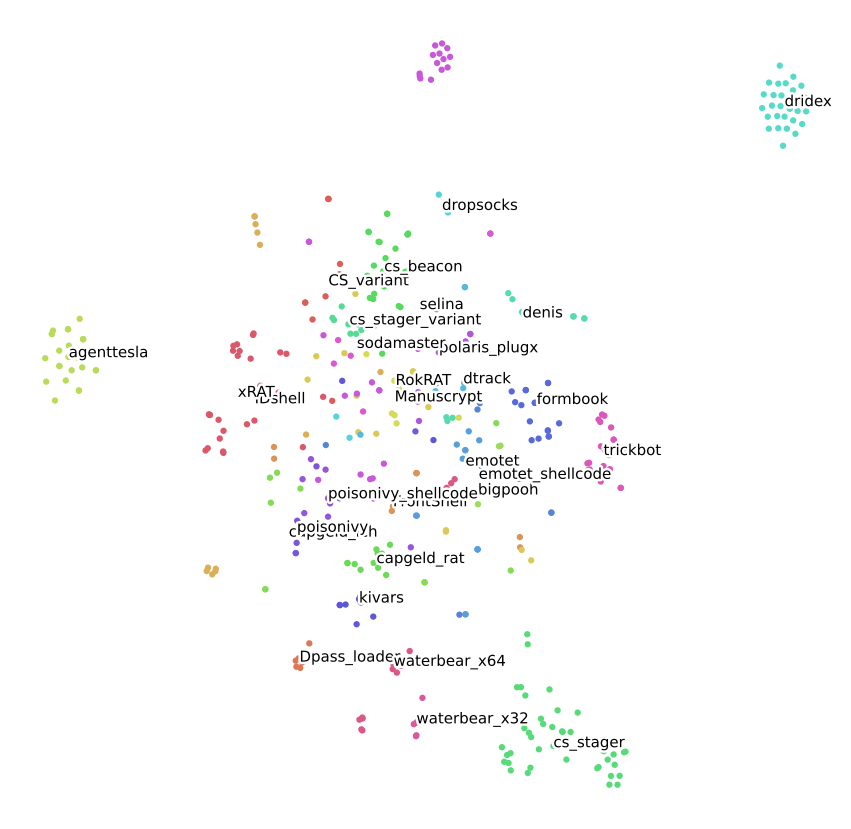

In [13]:
import matplotlib.pyplot as plt
import matplotlib.patheffects as PathEffects
import matplotlib
%matplotlib inline
def scatter(x, colors):
    # We choose a color palette with seaborn.
    palette = np.array(sns.color_palette("hls", num_classes))
    # We create a scatter plot.
    f = plt.figure(figsize=(15, 15))
    ax = plt.subplot(aspect='equal')
    sc = ax.scatter(x[:,0], x[:,1], lw=0, s=40,
                    c=palette[colors.astype(np.int)])
    plt.xlim(-25, 25)
    plt.ylim(-25, 25)
    ax.axis('off')
    ax.axis('tight')

    #add the labels for each class.
    txts = []
    for i in range(num_classes):
        # Position of each label.
        xtext, ytext = np.median(x[colors == i, :], axis=0)
        txt = ax.text(xtext, ytext, dict[i], fontsize=15)
        txt.set_path_effects([
            PathEffects.Stroke(linewidth=5, foreground="w"),
            PathEffects.Normal()])
        txts.append(txt)

    return f, ax, sc, txts
X_tsne = manifold.TSNE(n_components=2, init='random', random_state=5, verbose=1).fit_transform(y)
vis_val_y = np.array(val_y, dtype=np.float32)
scatter(X_tsne, vis_val_y)

saliency map

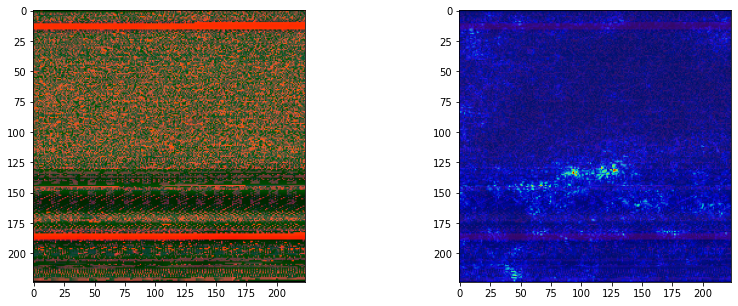

In [14]:
def saliency_map(model_inpput, image):
    if model_inpput == model_V3_test:
        target_size=(299,299)
    else:
        target_size=(224,224)   
    _img = keras.preprocessing.image.load_img(image,target_size= target_size)
    img1 = keras.preprocessing.image.img_to_array(_img)
    img1 = img1.reshape((1, *img1.shape))
    images = tf.Variable(img1, dtype=float)
    
    with tf.GradientTape() as tape:
        pred = model_inpput(images, training=False)
        class_idxs_sorted = np.argsort(pred.numpy().flatten())[::-1]
        loss = pred[0][class_idxs_sorted[0]]
    grads = tape.gradient(loss, images)
    dgrad_abs = tf.math.abs(grads)
    dgrad_max_ = np.max(dgrad_abs, axis=3)[0]
    arr_min, arr_max  = np.min(dgrad_max_), np.max(dgrad_max_)
    grad_eval = (dgrad_max_ - arr_min) / (arr_max - arr_min + 1e-18)
    fig, axes = plt.subplots(1,2,figsize=(14,5))
    axes[0].imshow(_img)
    i = axes[1].imshow(grad_eval,cmap="jet",alpha=0.8)
    plt.imshow(_img)
    plt.imshow(grad_eval,cmap="jet",alpha=0.8)
imagepath = 'Test/P8RAT/2021-01-11_23-32_da2bd4a55a6291bdb3e8a81a60091611.png'
model_VGG_test = VGG16(weights="imagenet", include_top=True)
model_V3_test = InceptionV3(weights="imagenet", include_top=True)  
saliency_map(model_VGG_test,imagepath)

draw gradcam heatmap

In [15]:
from pyimagesearch.gradcam import GradCAM
import cv2
import imutils
def Grad_cam(model_inpput, image):
    if model_inpput == model_V3_test:
        target_size=(299,299)
    else:
        target_size=(224,224)   
    orig = cv2.imread(image)
    _img = keras.preprocessing.image.load_img(image,target_size= target_size)
    _img = keras.preprocessing.image.img_to_array(_img)
    _img = np.expand_dims(_img, axis=0)
    _img = imagenet_utils.preprocess_input(_img)
    preds = model_inpput.predict(_img)
    i = np.argmax(preds[0])
    cam = GradCAM(model_inpput, i)
    heatmap = cam.compute_heatmap(_img)
    heatmap = cv2.resize(heatmap, (orig.shape[1], orig.shape[0]))
    (heatmap, output) = cam.overlay_heatmap(heatmap, orig, alpha=0.5)
    #output = np.vstack([orig, heatmap, output])
    #output = imutils.resize(output, height=700)
    #cv2.imshow("Output", output)
    #cv2.waitKey(0)
    fig, axes = plt.subplots(1,3,figsize=(14,5))
    axes[0].imshow(heatmap)
    axes[1].imshow(output)
    axes[2].imshow(orig)

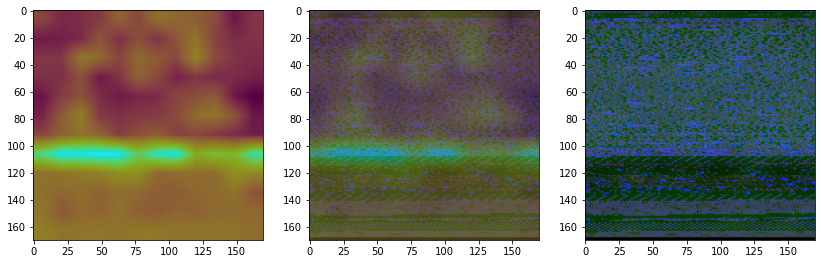

In [16]:
imagepath = '0318_png/Train/Dpass_loader/2016-12-21_11-48_d7ce9f6bc17f905eac37a9ab1fa53bd1.png'
Grad_cam(model_cnn,imagepath)

In [17]:
np.save('embedding',x)
np.save('label',train_y)

In [24]:
embedding = np.load('embedding.npy')
label = np.load('label.npy')

test = [imagepath]
vgg_test_features_flatten = create_vgg_features(test, model_vgg16)
v3_test_features_flatten = create_v3_features(test, model_V3)
cnn_test_features_flatten = create_cnn_feature(test, model_cnn1)
test__lbp_features_flatten = create_lbp_features(test)
t = np.append(vgg_test_features_flatten,v3_test_features_flatten,axis=1)
t = np.append(t,cnn_test_features_flatten,axis=1)
t = np.append(t,test__lbp_features_flatten,axis=1)
t = pca.transform(t)[0]
from scipy import spatial
index_x = spatial.KDTree(embedding).query(t,k=5)[1]
for i in index_x:
    print(dict[label[i]])

Dpass_loader
Dpass_loader
Dpass_loader
Dpass_loader
Dpass_loader
